#Time Series Data

There is a broad range of variability signatures that we need to be sensisitve to. From transient events such as GRBs to periodic variables. Analysis methods are related to  parameter estimation and model selection problems used in 
regression (the time variable $t$ replaces $x$). In many astronomical cases, characterization of the
underlying physical processes that produced the data is key (searches for pulsating vs eclipsing variable stars)
<!-- TEASER_END -->

<img src="figures/flare.png" style="float: left; width: 30%; margin-right: 1%;"> <img src="figures/cepheid.png" style="float: left; width: 30%; margin-right: 1%;"> <img src="figures/eclipsing.png" style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;">

##Is there something variable?

If the errors are known and Gaussian, we can simply compute $\chi^2$ and the corresponding $p$ values for variation in a signal

For a *sinusoidal* variable signal
- $y(t)=A\sin(\omega t)$ with constant errors ($\sigma$) 
- variance is $V=\sigma^2 + A^2/2$
 

 
If $A=0$ (no variability)
- $\chi^2_{\rm dof}=N^{-1} \sum_j (y_j/\sigma)^2 \sim V/\sigma^2$.
- $\chi^2_{\rm dof}$ has  expectation value of 1 and std dev  of $\sqrt{2/N}$

If $|A|>0$ (variability)
- $\chi^2_{\rm dof}$ will be larger
than 1. 
-  probability that $\chi^2_{\rm dof}>1 + 3 \sqrt{2/N}$  is about 1 in 1000

If this false-positive rate is acceptable then the minimum detectable amplitude is $A > 2.9 \sigma
/ N^{1/4}$ ( from $V/\sigma^2=1 + 3 \sqrt{2/N}$). 

For $N=100$ data points, the minimum detectable amplitude is $A=0.92\sigma$

For $N=1000$ $A = 0.52\sigma$ 

##Finding a chirp or burst in a time series

Imaging a stationary signal ($y(t)=b_0 + \epsilon$) with an injected signal at time $T$ (possibly followed by a decay to the original level $b_0$ over some unknown time period)

This injected signal could be a burst

> $y(t) = b_0 + A \exp(-\alpha (t-T))$.

or a chirp
 > $y(t) = b_0 + A \sin[\omega t + \beta t^2]$

We can identify the signal by forward modelling the data or using a matched filter (with MCMC to search for the parameter covariances). This assumes we can parameterize the model with a suitable set of parameters.

For complex signals we can marginalize over "nuisance" parameters (e.g. start time or phase) that arent important for our model

@pickle_results: using precomputed results from 'matchedfilt_chirp.pkl'


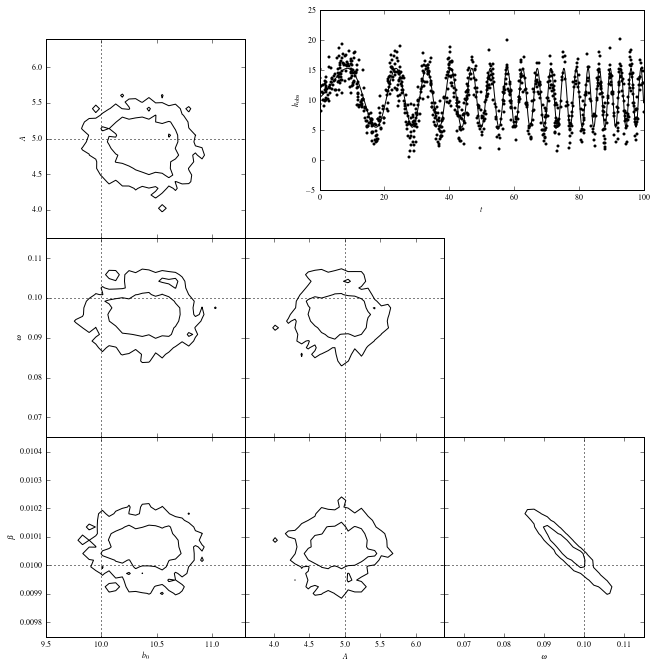

In [1]:
# Author: Jake VanderPlas
# License: BSD
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

import pymc

from astroML.plotting.mcmc import plot_mcmc
from astroML.decorators import pickle_results

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


#----------------------------------------------------------------------
# Set up toy dataset
def chirp(t, b0, beta, A, omega):
    return b0 + A * np.sin(omega * t + beta * t * t)

np.random.seed(0)

N = 1000
b0_true = 10
A_true = 5
beta_true = 0.01
omega_true = 0.1
sigma = 2.0

t = 100 * np.random.random(N)

y_true = chirp(t, b0_true, beta_true, A_true, omega_true)
y_obs = np.random.normal(y_true, sigma)

t_fit = np.linspace(0, 100, 1000)
y_fit = chirp(t_fit, b0_true, beta_true, A_true, omega_true)

i = np.argsort(t)

#----------------------------------------------------------------------
# Set up MCMC sampling
b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
log_beta = pymc.Uniform('log_beta', -10, 10, value=-4.6)
log_omega = pymc.Uniform('log_omega', -10, 10, value=-2.3)


# uniform prior on log(beta)
@pymc.deterministic
def beta(log_beta=log_beta):
    return np.exp(log_beta)


# uniform prior on log(omega)
@pymc.deterministic
def omega(log_omega=log_omega):
    return np.exp(log_omega)


@pymc.deterministic
def y_model(t=t, b0=b0, A=A, beta=beta, omega=omega):
    return chirp(t, b0, beta, A, omega)

y = pymc.Normal('y', mu=y_model, tau=sigma ** -2, observed=True, value=y_obs)

model = dict(b0=b0, A=A,
             log_beta=log_beta, beta=beta,
             log_omega=log_omega, omega=omega,
             y_model=y_model, y=y)


#----------------------------------------------------------------------
# Run the MCMC sampling (saving results to a pickle)
@pickle_results('matchedfilt_chirp.pkl')
def compute_MCMC_results(niter=20000, burn=2000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A', 'omega', 'beta']]

    M = pymc.MAP(model)
    M.fit()
    fit_vals = (M.b0.value, M.beta.value, M.A.value, M.omega.value)

    return traces, fit_vals

traces, fit_vals = compute_MCMC_results()

labels = ['$b_0$', '$A$', r'$\omega$', r'$\beta$']
limits = [(9.5, 11.3), (3.6, 6.4), (0.065, 0.115), (0.00975, 0.01045)]
true = [b0_true, A_true, omega_true, beta_true]

#----------------------------------------------------------------------
# Find the Maximum a posteriori values
fig = plt.figure(figsize=(10, 10))

ax = plt.axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 1001)
y_fit = chirp(t_fit, *fit_vals)
plt.scatter(t, y_obs, s=9, lw=0, c='k')
plt.plot(t_fit, y_fit, '-k')
plt.xlim(0, 100)
plt.xlabel('$t$')
plt.ylabel(r'$h_{\rm obs}$')

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels, limits=limits, true_values=true, fig=fig,
          bins=30, bounds=[0.12, 0.08, 0.95, 0.91], colors='k')
plt.show()

##Periodic signals

Many astrophysical sources have periodic signals (RR-Lyrae, Cepheids, eclipsing binaries)

We want to measure these periods from noisy and incomplete data

For a periodic signal
- $y(t+P) = y(t)$, where $P$ is the period 

-  phased light curve has the data  plotted as function of phase $\phi =   {t \over P} - {\rm int}\left( {t \over P} \right)$
- int($x$) returns the integer part of $x$.

<img src="figures/rrlyrae-good.png" style="float: left; width: 40%; margin-right: 1%;"> <img src="figures/rrlyrae-bad.png" style="float: left; width: 40%; margin-right: 1%;">

##A single sinusoid

If the data are drawn from a single sinusoidal signal

>$             y(t) = A \, \sin(\omega t + \phi) + \epsilon$

with $\epsilon$ the measurement noise. 

We can rewrite this as $\omega\,(t-t_o)$ (removing the phase term)


>$            y(t) = a\, \sin(\omega t) + b \, \cos(\omega t)$

where $A=(a^2+b^2)^{1/2}$ and $\phi = \tan^{-1}(b/a)$. 

The model is now linear with respect to coefficients $a$ and $b$ (and nonlinear only with respect to frequency $\omega$)


##Likelihood function

Assuming constant uncertainties on the data the likelihood for this model becomes,

> $L \equiv p(\{t,y\} |\omega,a,b,\sigma)=\prod_{j=1}^N  {1 \over \sqrt{2\pi} \sigma} \,
          \exp \left( {-[y_j - a\sin(\omega t_j) - b\cos(\omega t_j)]^2 \over 2 \sigma^2} \right).
$


Assuming uniform priors on $a$, $b$, $\omega$, and $\sigma$ (which gives nonuniform priors on $A$ and $\phi$) the posterior becomes

> $  p(\omega,a,b,\sigma|\{t,y\}) \propto \sigma^{-N}  \, \exp \left( { - N Q \over 2 \sigma^2} \right)$ 

with

>$Q= V - {2\over N} \left[ a \, I(\omega) + b \, R(\omega) - a\, b\, M(\omega) - {1 \over 2} a^2 \, S(\omega) - {1 \over 2} b^2 \,C(\omega)\right]$

and

>$            V = {1\over N} \sum_{j=1}^N y_j^2$

>$       I(\omega) = \sum_{j=1}^N y_j   \sin(\omega t_j)$

>$ R(\omega) = \sum_{j=1}^N y_j  \cos(\omega t_j)$

>$      M(\omega) = \sum_{j=1}^N \sin(\omega t_j) \, \cos(\omega t_j)$

>$      S(\omega) = \sum_{j=1}^N \sin^2(\omega t_j)$

>$C(\omega) = \sum_{j=1}^N  \cos^2(\omega t_j)$

*NOTE* I, R, M, S, C only depend on $\omega$ and the data

If N>>1 and we have data that extends longer than the period

$S(\omega) \approx C(\omega) \approx N/2$ and $M(\omega) \ll N/2$ and

>$Q \approx V - {2\over N} \left[ a \, I(\omega) + b \, R(\omega)\right]  + {1 \over 2} (a^2 + b^2)$

If we marginalize over $a$ and $b$ (as we are interested in the period)

>$  p(\omega,\sigma|\{t,y\}) \propto  \sigma^{-(N-2)} \exp \left( { - N V \over 2 \sigma^2} + { P(\omega) \over \sigma^2}       \right)$

with $P(\omega) = {1 \over N} [ I^2(\omega) + R^2(\omega)]$

if we know the noise $\sigma$ then 

>$   p(\omega|\{t,y\}, \sigma) \propto \exp \left( { P(\omega) \over \sigma^2} \right)$

and we now have the posterior for $\omega$

<img src="figures/periodogram.png">

Amplitude of the period signal can be derived from the posterior in much the same way as we do for MLE using

>$     \left. {d \, p(\omega,a,b,\sigma|\{t,y\}) \over d a} \right|_{a=a_0} = 0$

(and $d/db$ and the second derivatives) 

This gives
>$ a_0 = {2 I(\omega) \over N}$

>$b_0 = {2 R(\omega) \over N}$

and 
>$ \sigma_a = \sigma_b = \sigma \sqrt{2/N}$



###Significance of the peaks in the periodogram

What is the "best value" $\omega$? The $\chi^2$ is given by
> $\chi^2(\omega) \equiv {1 \over \sigma^2} \sum_{j=1}^N [y_j-y(t_j)]^2 =
  {1 \over \sigma^2} \sum_{j=1}^N [y_j- a_0\, \sin(\omega t_j) - b_0 \, \cos(\omega t_j)]^2$
  
or

> $\chi^2(\omega) =  \chi_0^2 \, \left[1 - {2 \over N \, V}  \, P(\omega) \right]$

with $P(\omega)$ is the periodogram and $\chi_0^2$ the $\chi^2$ for a model $y(t)$=constant

>$  \chi_0^2 = {1 \over \sigma^2} \sum_{j=1}^N y_j^2 = {N \, V \over \sigma^2}$

We can now renormalise the periodogram with 

${2 \over N \, V}  \, P(\omega)$ so $0 \le P_{\rm LS}(\omega) \le 1$

###This is known as the Lomb-Scargle periodogram
###(except LS allows for point dependent errors)

If the true frequency is $\omega_0$ then the maximum peak in the periodogram should have a height

>$P(\omega_0) = {N \over 4} (a_0^2 + b_0^2)$

and standard deviation
>$      \sigma_P(\omega_0)  = {\sqrt{2} \over 2} \, \sigma^2$

Properties of LS and the periodogram
- The expected heights of the peaks in a periodogram dont depend on $\sigma$ but their variation in height do
- For $P_{\rm LS}(\omega_0)$, with no noise the peak approaches 1. As noise increases, $P_{\rm LS}(\omega_0)$ decreases and is ``buried'' in the background  noise
- To estimate the uncertainty on the peaks you can use a bootstrap approach
- A generalized version of LS fits for the mean value of $y$ (as we may not have enough samples to be confident of the mean)

/Users/ajc/LSST/Software/lsst/DarwinX86/anaconda/2.1.0-4-g35ca374/lib/python2.7/site-packages/astroML/time_series/periodogram.py:8: UserWarning: Using slow version of lomb_scargle. Install astroML_addons to use an optimized version
  warnings.warn("Using slow version of lomb_scargle. Install astroML_addons "


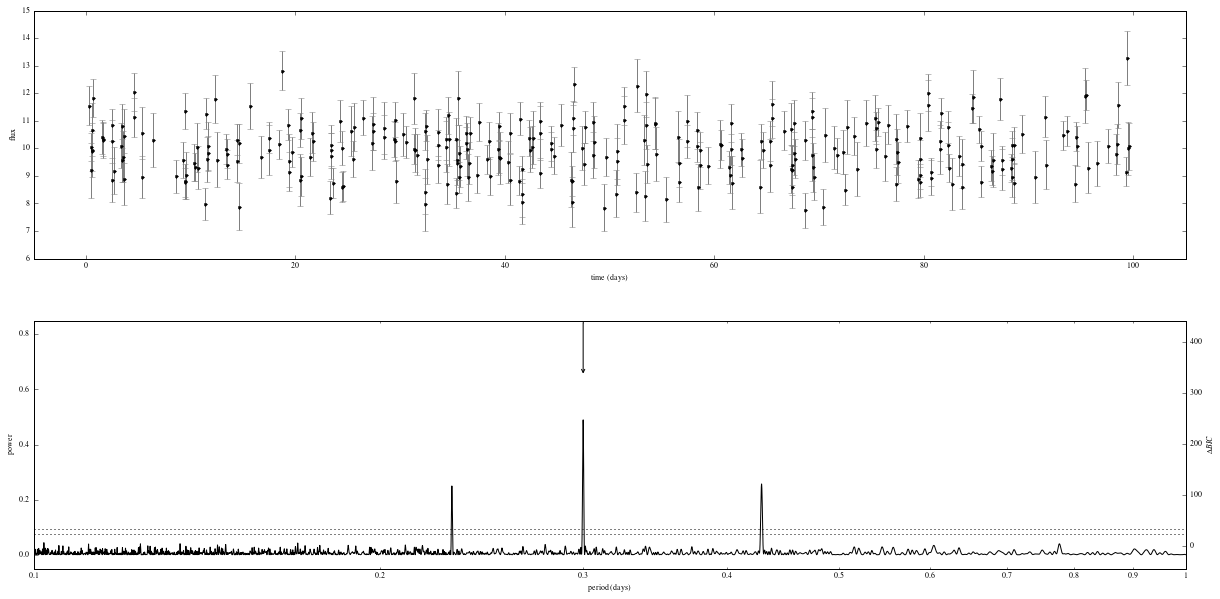

In [2]:
# Author: Jake VanderPlas
# License: BSD
from matplotlib import pyplot as plt
from astroML.time_series import\
    lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Generate Data
np.random.seed(0)
N = 300
P = 0.3

t = np.random.randint(100, size=N) + 0.3 + 0.4 * np.random.random(N)
y = 10 + np.sin(2 * np.pi * t / P)
dy = 0.5 + 0.5 * np.random.random(N)
y_obs = np.random.normal(y, dy)

#------------------------------------------------------------
# Compute periodogram
period = 10 ** np.linspace(-1, 0, 10000)
omega = 2 * np.pi / period
PS = lomb_scargle(t, y_obs, dy, omega, generalized=True)

#------------------------------------------------------------
# Get significance via bootstrap
D = lomb_scargle_bootstrap(t, y_obs, dy, omega, generalized=True,
                           N_bootstraps=1000, random_state=0)
sig1, sig5 = np.percentile(D, [99, 95])

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(left=0.1, right=0.9, hspace=0.25)

# First panel: the data
ax = fig.add_subplot(211)
ax.errorbar(t, y_obs, dy, fmt='.k', lw=1, ecolor='gray')
ax.set_xlabel('time (days)')
ax.set_ylabel('flux')
ax.set_xlim(-5, 105)

# Second panel: the periodogram & significance levels
ax1 = fig.add_subplot(212, xscale='log')
ax1.plot(period, PS, '-', c='black', lw=1, zorder=1)
ax1.plot([period[0], period[-1]], [sig1, sig1], ':', c='black')
ax1.plot([period[0], period[-1]], [sig5, sig5], ':', c='black')

ax1.annotate("", (0.3, 0.65), (0.3, 0.85), ha='center',
             arrowprops=dict(arrowstyle='->'))

ax1.set_xlim(period[0], period[-1])
ax1.set_ylim(-0.05, 0.85)

ax1.set_xlabel(r'period (days)')
ax1.set_ylabel('power')

# Twin axis: label BIC on the right side
ax2 = ax1.twinx()
ax2.set_ylim(tuple(lomb_scargle_BIC(ax1.get_ylim(), y_obs, dy)))
ax2.set_ylabel(r'$\Delta BIC$')

ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax1.xaxis.set_minor_formatter(plt.FormatStrFormatter('%.1f'))
ax1.xaxis.set_major_locator(plt.LogLocator(10))
ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3g'))

plt.show()

##Multiband LS periodograms


<img src="figures/multibandLS.png" style="float: right; width: 100%; margin-right: 1%;">


With projects like the LSST there will be sparsely sampled light curves (in multiple passbands). The generalized LS was an extension to account for the mean value. We can build on this to account for multiple bands by fitting for a global period and a per band period

$\begin{eqnarray}
  &y_k(t|\omega,\theta) =
  \theta_0 + \sum_{n=1}^{N_{base}} \left[\theta_{2n - 1}\sin(n\omega t) + \theta_{2n}\cos(n\omega t)\right] +&\nonumber
  &\theta^{(k)}_0 + \sum_{n=1}^{N_{band}} \left[\theta^{(k)}_{2n - 1}\sin(n\omega t) + \theta^{(k)}_{2n}\cos(n\omega t)\right].&
\end{eqnarray}$

The total number of parameters for $K$ filters is then $M_K = (2N_{base} + 1) + K(2N_{band} + 1)$. 

To keep the parameters constrained we apply regularization (see regression)

The important feature of this model is that _all bands_ share the same base parameters $\theta$, while their offsets $\theta^{(k)}$ are determined individually.

###Install
pip install gatspy

pip install supersmoother

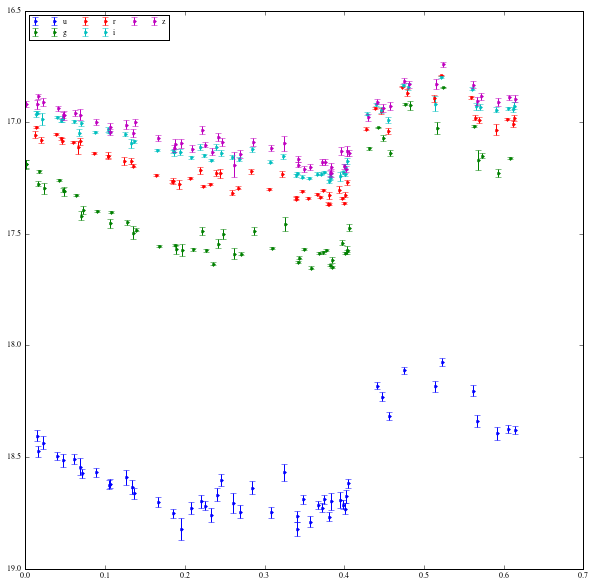

In [3]:
from gatspy.datasets import fetch_rrlyrae
rrlyrae = fetch_rrlyrae()
lcid = rrlyrae.ids[0]

t, y, dy, filts = rrlyrae.get_lightcurve(lcid)
period = rrlyrae.get_metadata(lcid)['P']

fig = plt.figure(figsize=(10,10))
for filt in 'ugriz':
    mask = (filts == filt)
    plt.errorbar(t[mask] % period, y[mask], dy[mask], fmt='.', label=filt)
plt.gca().invert_yaxis()
plt.legend(ncol=3, loc='upper left');

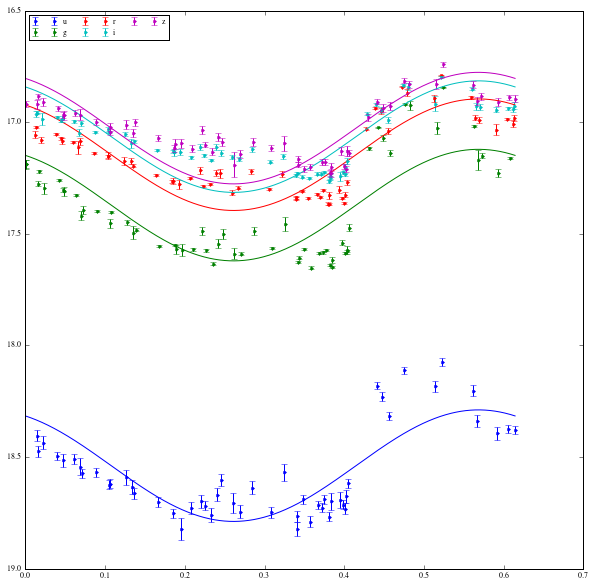

In [5]:
from gatspy.periodic import LombScargleMultiband
model = LombScargleMultiband(Nterms_base=1, Nterms_band=0)
model.fit(t, y, dy, filts)
periods = np.linspace(period - 0.1, period + 0.1, 2000)
power = model.periodogram(periods)

def plot_model(model, lcid):
    t, y, dy, filts = rrlyrae.get_lightcurve(lcid)
    model.fit(t, y, dy, filts)
    
    tfit = np.linspace(0, period, 1000)
    for filt in 'ugriz':
        mask = (filts == filt)
        eb = plt.errorbar(t[mask] % period, y[mask], dy[mask], fmt='.', label=filt)
        yfit = model.predict(tfit, filt, period=period)
        plt.plot(tfit, yfit, color=eb[0].get_color())
    plt.gca().invert_yaxis()
    plt.legend(ncol=3, loc='upper left')
    
fig = plt.figure(figsize=(10,10))
plot_model(LombScargleMultiband(Nterms_base=1, Nterms_band=0), lcid)

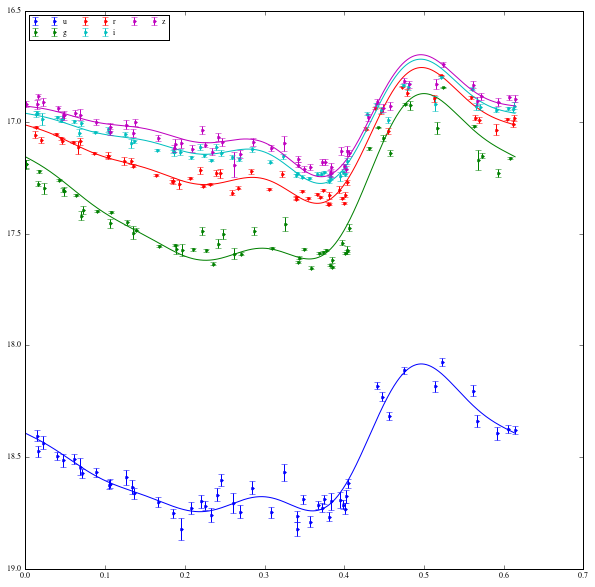

In [8]:
fig = plt.figure(figsize=(10,10))
plot_model(LombScargleMultiband(Nterms_base=4, Nterms_band=1), lcid)